In [1]:
import sklearn as sk
import pandas as pd
import numpy as np
from os import getenv
from datetime import datetime
from amb_sdk.sdk import DarwinSdk
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_rows', None)

In [3]:
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')

status, msg = ds.auth_login_user('danny.diaz@utexas.edu','JcXCnQ7Wx2')
if not status:
    print(msg)
status

True

In [6]:
cycle_df = pd.read_csv('./data/Austin_B-Cycle_Trips.csv')
weather_df = pd.read_csv('./data/austin_weather.csv')

In [8]:
cycle_df['Checkout Date'] = pd.to_datetime(
    cycle_df['Checkout Date'], infer_datetime_format=True
    ).dt.normalize() #strftime('%m/%d/%Y') # format='%m/%d/%Y').dt.date

cycle_df['Checkout Time'] = pd.to_timedelta(
    cycle_df['Checkout Time']) #, format='%H:%M:%S')\
#.dt.strftime('%H:%M') #This turns it back to a object dtype

print(cycle_df.dtypes)
cycle_df.head()
#cycle_df.shape

Trip ID                            int64
Membership Type                   object
Bicycle ID                       float64
Checkout Date             datetime64[ns]
Checkout Time            timedelta64[ns]
Checkout Kiosk ID                float64
Checkout Kiosk                    object
Return Kiosk ID                  float64
Return Kiosk                      object
Trip Duration Minutes              int64
Month                            float64
Year                             float64
dtype: object


,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year
0,9900285854,Annual (San Antonio B-cycle),207.0,2014-10-26,13:12:00,2537.0,West & 6th St.,2707.0,Rainey St @ Cummings,76,10.0,2014.0
1,9900285855,24-Hour Kiosk (Austin B-cycle),969.0,2014-10-26,13:12:00,2498.0,Convention Center / 4th St. @ MetroRail,2566.0,Pfluger Bridge @ W 2nd Street,58,10.0,2014.0
2,9900285856,Annual Membership (Austin B-cycle),214.0,2014-10-26,13:12:00,2537.0,West & 6th St.,2496.0,8th & Congress,8,10.0,2014.0
3,9900285857,24-Hour Kiosk (Austin B-cycle),745.0,2014-10-26,13:12:00,NaN,Zilker Park at Barton Springs & William Barton...,NaN,Zilker Park at Barton Springs & William Barton...,28,10.0,2014.0
4,9900285858,24-Hour Kiosk (Austin B-cycle),164.0,2014-10-26,13:12:00,2538.0,Bullock Museum @ Congress & MLK,NaN,Convention Center/ 3rd & Trinity,15,10.0,2014.0


,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year
0,9900285854,Annual (San Antonio B-cycle),207.0,2014-10-26,13:12:00,2537.0,West & 6th St.,2707.0,Rainey St @ Cummings,76,10,2014
1,9900285855,24-Hour Kiosk (Austin B-cycle),969.0,2014-10-26,13:12:00,2498.0,Convention Center / 4th St. @ MetroRail,2566.0,Pfluger Bridge @ W 2nd Street,58,10,2014
2,9900285856,Annual Membership (Austin B-cycle),214.0,2014-10-26,13:12:00,2537.0,West & 6th St.,2496.0,8th & Congress,8,10,2014
3,9900285857,24-Hour Kiosk (Austin B-cycle),745.0,2014-10-26,13:12:00,NaN,Zilker Park at Barton Springs & William Barton...,NaN,Zilker Park at Barton Springs & William Barton...,28,10,2014
4,9900285858,24-Hour Kiosk (Austin B-cycle),164.0,2014-10-26,13:12:00,2538.0,Bullock Museum @ Congress & MLK,NaN,Convention Center/ 3rd & Trinity,15,10,2014
5,9900285859,24-Hour Kiosk (Austin B-cycle),37.0,2014-10-26,13:12:00,NaN,Zilker Park at Barton Springs & William Barton...,2545.0,ACC - Rio Grande & 12th,26,10,2014
6,9900285860,Annual Membership (Austin B-cycle),517.0,2014-10-26,13:12:00,2496.0,8th & Congress,2561.0,State Capitol Visitors Garage @ San Jacinto & ...,35,10,2014
7,9900285861,Annual Membership (Austin B-cycle),996.0,2014-10-26,13:12:00,2569.0,East 11th St. & San Marcos,2499.0,City Hall / Lavaca & 2nd,11,10,2014
8,9900285862,Annual Membership (Austin B-cycle),517.0,2014-10-26,13:12:00,2496.0,8th & Congress,2496.0,8th & Congress,0,10,2014
9,9900285863,24-Hour Kiosk (Austin B-cycle),385.0,2014-10-26,13:12:00,NaN,Zilker Park at Barton Springs & William Barton...,2545.0,ACC - Rio Grande & 12th,25,10,2014


In [54]:
"""
Explored the Checkout Kiosk and Return Kiosk ID columns. Found out that the rows with missing values
are specific to certain kiosks. By dropping these columns we do not lose any information so I decided to 
drop them.
"""

# no_kiosk_id_df = cycle_df[pd.isnull(cycle_df[['Checkout Kiosk ID','Return Kiosk ID']], axis=1)]

no_kiosk_id_df = cycle_df[cycle_df[['Checkout Kiosk ID','Return Kiosk ID']].isnull().any(axis=1)]

no_kiosk_id_df.head(150)
# Produced about 42000 rows that had atleast one of the 2 columns as null values.

cycle_df = cycle_df.drop(['Checkout Kiosk ID','Return Kiosk ID'], axis=1)

In [57]:
# In this cell I fill in all of the blank values for Month and Year 
# columns I do this before I remove dates that fall outside the 
# weather dates. 


cycle_df['Month'] = cycle_df.apply(lambda x: x['Checkout Date'].month, axis=1)

cycle_df['Year']  = cycle_df.apply(lambda x: x['Checkout Date'].year, axis=1)

# month_df = cycle_df.apply(lambda x: pd.Series({'Month': x['Checkout Date'].month, 
#                                                'Year' : x['Checkout Date'].year}), axis=1)


month_df = cycle_df[pd.isnull(cycle_df['Month'])]

# check to make sure that all columns have a month value. Should return 0
len(month_df)

0

In [33]:
weather_df['Date'] = pd.to_datetime(
    weather_df['Date'], infer_datetime_format=True
    ).dt.normalize() #strftime('%m/%d/%Y') # format='%m/%d/%Y').dt.date

#print(weather_df.dtypes)

In [56]:
# Check the date range for both csv files

print('Cycle Trips Earliest Data',cycle_df['Checkout Date'].dt.date.min())
print('Cycle Trips Latest Data',cycle_df['Checkout Date'].dt.date.max())

print('Weather Earliest Data',weather_df['Date'].dt.date.min())
print('Weather Latest Data',weather_df['Date'].dt.date.max())

Cycle Trips Earliest Data 2013-12-21
Cycle Trips Latest Data 2017-07-31
Weather Earliest Data 2013-12-21
Weather Latest Data 2017-07-31


In [50]:
# all cycle df variants are initiated here and then added to the all list below

cycle_df = cycle_df[
    cycle_df['Checkout Date'].between('2013-12-21', 
                                            '2017-07-31', 
                                            inclusive=True)
]


cycle_df_no_0_2 = cycle_df.drop(cycle_df[
    cycle_df['Trip Duration Minutes'].isin([0,1,2])].index)

cycle_df_only_0_2 = cycle_df.drop(cycle_df[
    cycle_df['Trip Duration Minutes'] > 2].index)

cycle_df_less_75_min =  cycle_df.drop(cycle_df[
    cycle_df['Trip Duration Minutes'] > 75].index)

cycle_df_longer_75_min =  cycle_df.drop(cycle_df[
    cycle_df['Trip Duration Minutes'] < 75].index)



all_cycle_df = [cycle_df,
                cycle_df_no_0_2,cycle_df_only_0_2, 
                cycle_df_less_75_min, cycle_df_longer_75_min,
               ]


for df in all_cycle_df:
    print(df.shape)
#cycle_trips_df[cycle_trips_df['Trip ID'] == 16553021]



(649231, 12)
(620432, 12)
(28799, 12)
(604383, 12)
(45758, 12)


In [58]:
# I made this file once I filled in all months and year columns
#cycle_df.to_csv('./data/Filled_Cycle_Trips.csv')

# I made this after I removed both Checkout and Return Kiosk ID columns
# cycle_df.to_csv('./data/Cleaned_Cycle_Trips.csv')

# Made this csv after I aligned the dates with the weather CSV this one is small enough to add to Github
# cycle_df.to_csv('./data/Cleaned_Cycle_Trips_Weather_Dates.csv')

#The 3 changes suggested above build on themselves. so the last csv file has the changes made to the first 2.


In [111]:
all_weather_df = [weather_df,]

In [328]:
#Unnecessary cell

weather_df = weather_df[
  weather_df['Date'].between('2013-12-21','2017-07-31',inclusive=True)  
]

In [59]:
cycle_df.describe()

,Trip ID,Bicycle ID,Checkout Time,Trip Duration Minutes,Month,Year
count,6.492310e+05,648508.000000,649231,649231.000000,649231.000000,649231.000000
mean,5.384945e+09,471.615214,0 days 14:39:09.178840,29.127506,5.915084,2015.418654
std,4.925349e+09,323.588379,0 days 04:28:38.969400,87.278642,3.133885,1.055942
min,8.269930e+06,3.000000,0 days 00:02:01,0.000000,1.000000,2013.000000
25%,1.274709e+07,208.000000,0 days 12:12:00,8.000000,3.000000,2015.000000
50%,9.900028e+09,417.000000,0 days 15:09:29,15.000000,6.000000,2015.000000
75%,9.900190e+09,745.000000,0 days 17:52:01,28.000000,9.000000,2016.000000
max,9.900353e+09,5089.000000,0 days 23:57:59,21296.000000,12.000000,2017.000000


In [329]:
print(weather_df.shape)
weather_df.head(5)

(1319, 21)


,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,...,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,...,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,...,30.13,29.87,10,10,5,16,6,25,0,
2,2013-12-23,58,45,32,31,27,23,76,52,27,...,30.49,30.41,10,10,10,8,3,12,0,
3,2013-12-24,61,46,31,36,28,21,89,56,22,...,30.45,30.3,10,10,7,12,4,20,0,
4,2013-12-25,58,50,41,44,40,36,86,71,56,...,30.33,30.27,10,10,7,10,2,16,T,


## Notes  
The dates we are going to use are 12/21/13 to 7/31/17.


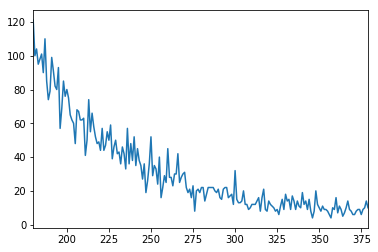

In [129]:
df = all_cycle_df[4]
#plt.ylim(0,1500)
df['Trip Duration Minutes'].value_counts().sort_index().head(200).plot()

#cycle_df_only_0_2['Trip Duration Minutes'].value_counts().sort_index().head(40).plot()
#.sort_values(ascending=False)
#.head(50).plot()

Seems like the trip duration is an exponential decay.

In [130]:
for df in all_cycle_df:
    df['Checkout WeekDay'] = df['Checkout Date'].dt.day_name()
    
for df in all_weather_df:
    df['Weekday'] = df['Date'].dt.day_name()

# cycle_df['Checkout WeekDay'] = \
#         cycle_trips_df['Checkout Date'].dt.day_name()

# weather_df['Weekday'] = weather_df['Date'].dt.day_name()

# cycle_df_no_0_2['Checkout WeekDay'] = \
#         cycle_trips_df['Checkout Date'].dt.day_name()


cycle_df['Checkout WeekDay'].head()

0    Sunday
1    Sunday
2    Sunday
3    Sunday
4    Sunday
Name: Checkout WeekDay, dtype: object

In [131]:
df = all_cycle_df[4]

cycle_weekdays = df.groupby('Checkout WeekDay')
cycle_months   = df.groupby('Month')
cycle_checkout = df.groupby('Checkout Kiosk')
cycle_return   = df.groupby('Return Kiosk')

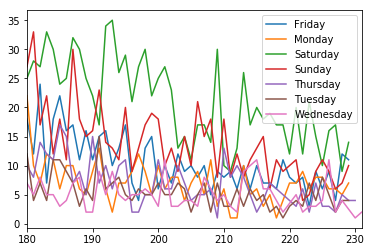

In [133]:
for name,group in cycle_weekdays:
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(50).plot(legend=True,label=name)

## Notes  
Trips are twice as long on Saturday and Sunday then all other days. (~11-12 min compared to ~6-7)  
The distribution of Friday Saturday and Sunday is right shifted compared to the 4 days.  
Monday-Thursday distributions are nearly identical.   

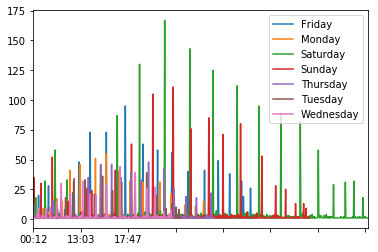

In [134]:
for index,(name,group) in enumerate(cycle_weekdays):
#     if index not in [1,6]:
#         continue
    group['Checkout Time'].value_counts().sort_index()\
    .plot(legend=True,label=name)

## Notes
Majority trips between midnight and 3 am are on saturday and sunday.  
Thursday, Tuesday, Monday are about the same. Thursday is slightly taller in the afternoon.  
Tuesday and Wednesday are practically identical.   
Monday is slightly taller than Wednesday during peak hours.  

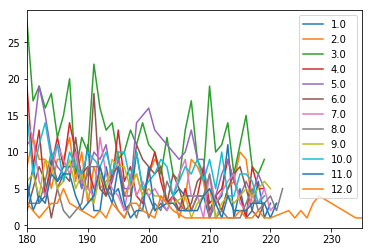

In [135]:
for index,(name,group) in enumerate(cycle_months):
#     if 4 < index < 9 :
#         continue
#     elif index >12:
#         continue 
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(40).plot(legend=True,label=name)
    

## Notes
March is the most popular month.  
October and May are tied for second but October trips length are a bit longer.  
December is the least popular month by far.  
June through September are practically identical.  
January, February, and April are about the same, with February being the lowest.  
February is about tied with November.  

Overall there are 4 tiers:  
1. March 
2. May and October
3. All months besides December
4. December

In [136]:
for name,group in cycle_checkout:
    print('Checkout',name)
    print(group['Return Kiosk'].value_counts().head(5))#\
    print('\n')


Checkout 11th & San Jacinto
11th & San Jacinto          12
Lavaca & 6th                 4
Red River & 8th Street       3
South Congress & James       2
ACC - West & 12th Street     1
Name: Return Kiosk, dtype: int64


Checkout 13th & San Antonio
Capitol Station / Congress & 11th    2
13th & San Antonio                   1
Davis at Rainey Street               1
Name: Return Kiosk, dtype: int64


Checkout 17th & Guadalupe
17th & Guadalupe                     47
UT West Mall @ Guadalupe             10
Capitol Station / Congress & 11th     7
Guadalupe & 21st                      6
Trinity & 6th Street                  6
Name: Return Kiosk, dtype: int64


Checkout 2nd & Congress
2nd & Congress              202
Davis at Rainey Street       18
4th & Congress               16
City Hall / Lavaca & 2nd     16
South Congress & James       12
Name: Return Kiosk, dtype: int64


Checkout 3rd & West
3rd & West                           49
City Hall / Lavaca & 2nd             10
Pfluger Bridge @ W 2nd

In [395]:
df = cycle_df
df = cycle_df_no_0_2

checkout_return_pairs = cycle_df.\
    groupby(['Checkout Kiosk','Return Kiosk']).size().reset_index()\
    .rename(columns={0:'counts'}) #.value_counts().head(15).plot(kind='bar')

checkout_return_pairs = checkout_return_pairs\
    .sort_values('counts', ascending=False).reset_index()

total_trips = checkout_return_pairs['counts'].sum()

checkout_return_pairs['freq_%'] = checkout_return_pairs['counts']\
    .map(lambda x: round(x/total_trips*100,4))

# checkout_return_pairs = checkout_return_pairs.\
#     set_index('freq_%').sort_index(ascending=False)

print(total_trips)
print(checkout_return_pairs.shape)

checkout_return_pairs.head(100)



# checkout_return_pairs['freq']

620432
(5098, 5)


,index,Checkout Kiosk,Return Kiosk,counts,freq_%
0,3949,Riverside @ S. Lamar,Riverside @ S. Lamar,7799,1.2570
1,3574,Rainey St @ Cummings,Rainey St @ Cummings,4997,0.8054
2,196,2nd & Congress,2nd & Congress,3681,0.5933
3,1572,City Hall / Lavaca & 2nd,City Hall / Lavaca & 2nd,3422,0.5516
4,4987,Zilker Park,Zilker Park,3226,0.5200
5,5097,Zilker Park at Barton Springs & William Barton...,Zilker Park at Barton Springs & William Barton...,3125,0.5037
6,3355,Pfluger Bridge @ W 2nd Street,Pfluger Bridge @ W 2nd Street,3077,0.4959
7,1489,Capitol Station / Congress & 11th,Capitol Station / Congress & 11th,2929,0.4721
8,3225,Palmer Auditorium,Palmer Auditorium,2571,0.4144
9,993,Barton Springs & Riverside,Barton Springs & Riverside,2527,0.4073


In [460]:
df = all_cycle_df[]

groups = cycle_df.\
    groupby(['Checkout Kiosk','Return Kiosk'])


columns = ['Checkout Kiosk','Return Kiosk', 'Avg Trip Duration', 
          'Mode Trip Duration']
checkout_return_pairs_avg = pd.DataFrame(columns=columns)
for (checkout, checkin),group in groups:
    checkout_return_pairs_avg = checkout_return_pairs_avg\
        .append({col_name: value for col_name, value in 
                 zip(columns,[checkout,checkin,
                group['Trip Duration Minutes'].mean(),
                group['Trip Duration Minutes'].mode().max()])
                }, ignore_index=True)

checkout_return_pairs_avg.shape

# .size().reset_index()\
#     .rename(columns={0:'counts'})

(5110, 4)

In [27]:
checkout_return_pair_data.head(20)

NameError: name 'checkout_return_pair_data' is not defined

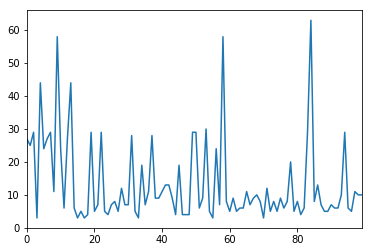

In [421]:
checkout_return_pair_data = pd.merge(checkout_return_pairs, 
                                     checkout_return_pairs_avg,
                                     how='inner',
                                    left_on=['Checkout Kiosk',
                                             'Return Kiosk'],
                                    right_on=['Checkout Kiosk',
                                             'Return Kiosk'],
                                    )
checkout_return_pair_data['Mode Trip Duration'].head(100).plot()


Most of the long trip durations are returned to the station they were checked out of.

All of the short trips are returned at a different station.

In [458]:
checkout_return_pair_data[checkout_return_pair_data[
    'Avg Trip Duration'
] < 15].head(15)


,index,Checkout Kiosk,Return Kiosk,counts,freq_%,Avg Trip Duration,Mode Trip Duration
11,439,5th & Bowie,4th & Congress,2429,0.3915,8.991354,6
14,357,4th & Congress,5th & Bowie,2251,0.3628,11.327410,6
16,457,5th & Bowie,City Hall / Lavaca & 2nd,2124,0.3423,11.005179,5
18,296,3rd & West,City Hall / Lavaca & 2nd,1855,0.2990,8.933693,4
20,1764,Convention Center / 4th St. @ MetroRail,City Hall / Lavaca & 2nd,1790,0.2885,13.854749,5
23,1555,City Hall / Lavaca & 2nd,5th & Bowie,1666,0.2685,11.029412,5
24,3823,Republic Square @ Guadalupe & 4th St.,5th & Bowie,1653,0.2664,7.770115,4
26,460,5th & Bowie,Convention Center / 4th St. @ MetroRail,1509,0.2432,13.652750,8
27,278,3rd & West,4th & Congress,1499,0.2416,9.168779,5
35,437,5th & Bowie,2nd & Congress,1318,0.2124,12.780728,7


In [459]:
checkout_return_pair_data[checkout_return_pair_data[
    'Avg Trip Duration'
] > 25].head(15)

,index,Checkout Kiosk,Return Kiosk,counts,freq_%,Avg Trip Duration,Mode Trip Duration
0,3949,Riverside @ S. Lamar,Riverside @ S. Lamar,7799,1.2570,52.916015,27
1,3574,Rainey St @ Cummings,Rainey St @ Cummings,4997,0.8054,63.470082,25
2,196,2nd & Congress,2nd & Congress,3681,0.5933,75.861451,29
3,1572,City Hall / Lavaca & 2nd,City Hall / Lavaca & 2nd,3422,0.5516,74.004383,3
4,4987,Zilker Park,Zilker Park,3226,0.5200,59.846559,44
5,5097,Zilker Park at Barton Springs & William Barton...,Zilker Park at Barton Springs & William Barton...,3125,0.5037,53.919360,24
6,3355,Pfluger Bridge @ W 2nd Street,Pfluger Bridge @ W 2nd Street,3077,0.4959,57.786155,27
7,1489,Capitol Station / Congress & 11th,Capitol Station / Congress & 11th,2929,0.4721,54.652783,29
8,3225,Palmer Auditorium,Palmer Auditorium,2571,0.4144,64.497083,11
9,993,Barton Springs & Riverside,Barton Springs & Riverside,2527,0.4073,77.552434,58
